<h1>Corona Virus 2019 (COVID19) Data Analysis</h1>
<img src="https://www.kabiraugandasafaris.com/wp-content/uploads/2020/03/Coronavirus-Disease-COVID-19.png" width="1920" height="420">

In [60]:
import duckdb
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

In [20]:
def get_df(sql: str):
    con = duckdb.connect("/data/duckdb/github_dw.duckdb", read_only=True)
    return con.query(sql).to_df()

## What are the top 10 countries with most confirmed cases?

In [218]:
q1 = """
WITH country_confirmed AS (
    SELECT 
        SUM(f.confirmed) AS total_confirmed
        ,l.country
    FROM curated.fact_covid_cases AS f
    JOIN curated.dim_location l ON l.location_id = f.location_id
    GROUP BY country
)
, top_10_confirmed AS (
    SELECT
        DENSE_RANK() OVER(ORDER BY total_confirmed DESC) AS ranking
        ,country
        ,total_confirmed
    FROM country_confirmed
    QUALIFY ranking <= 10
)
SELECT *
FROM top_10_confirmed;
"""
get_df(q1)


,ranking,country,total_confirmed
0,1,United states,108663056.0
1,2,India,45213738.0
2,3,France,40264917.0
3,4,Germany,39006310.0
4,5,Brazil,37079460.0
5,6,Japan,33424921.0
6,7,South korea,30526121.0
7,8,Italy,25586555.0
8,9,United kingdom,24936012.0
9,10,Russia,21952249.0


## What are the top 10 countries with most death cases?

In [13]:
q2 = """
WITH country_deaths AS (
    SELECT 
        SUM(f.deaths) AS total_deaths
        ,l.country
    FROM curated.fact_covid_cases AS f
    JOIN curated.dim_location l ON l.location_id = f.location_id
    GROUP BY country
)
, top_10_deaths AS (
    SELECT
        DENSE_RANK() OVER(ORDER BY total_deaths DESC) AS ranking
        ,country
        ,total_deaths
    FROM country_deaths
    QUALIFY ranking <= 10
)
SELECT *
FROM top_10_deaths;
"""
get_df(q2)

,ranking,country,total_deaths
0,1,United states,1248696.0
1,2,Brazil,698856.0
2,3,India,531839.0
3,4,Peru,488372.0
4,5,Russia,387994.0
5,6,Mexico,354091.0
6,7,United kingdom,220766.0
7,8,Italy,187980.0
8,9,Germany,168550.0
9,10,France,167785.0


## What are the top 10 countries with least confirmed cases?

In [23]:
q3 = """
WITH country_confirmed AS (
    SELECT 
        SUM(f.confirmed) AS total_confirmed
        ,l.country
    FROM curated.fact_covid_cases AS f
    JOIN curated.dim_location l ON l.location_id = f.location_id
    GROUP BY country
)
, top_10_confirmed AS (
    SELECT
        DENSE_RANK() OVER(ORDER BY total_confirmed) AS ranking
        ,country
        ,total_confirmed
    FROM country_confirmed
    WHERE total_confirmed > 0
    QUALIFY ranking <= 10 
)
SELECT *
FROM top_10_confirmed;
"""
get_df(q3)

,ranking,country,total_confirmed
0,1,North korea,1.0
1,1,Faroe islands,1.0
2,2,Aruba,2.0
3,3,Mayotte,6.0
4,4,Macau,9.0
5,5,Antarctica,11.0
6,6,French guiana,13.0
7,7,Holy see,28.0
8,8,Martinique,30.0
9,9,Reunion,40.0


## What are the top 10 countries with least death cases?

In [25]:
q4 = """
WITH country_deaths AS (
    SELECT 
        SUM(f.deaths) AS total_deaths
        ,l.country
    FROM curated.fact_covid_cases AS f
    JOIN curated.dim_location l ON l.location_id = f.location_id
    GROUP BY country
)
, top_10_deaths AS (
    SELECT
        DENSE_RANK() OVER(ORDER BY total_deaths) AS ranking
        ,country
        ,total_deaths
    FROM country_deaths
    WHERE total_deaths > 0
    QUALIFY ranking <= 10
)
SELECT *
FROM top_10_deaths;
"""
get_df(q4)

,ranking,country,total_deaths
0,1,Martinique,1.0
1,1,Nauru,1.0
2,2,Hong kong,3.0
3,3,North korea,6.0
4,4,Palau,9.0
5,5,Vanuatu,14.0
6,5,Tonga,14.0
7,6,Marshall islands,17.0
8,7,Kiribati,18.0
9,8,Bhutan,21.0


## How many daily deaths on average per country?

In [33]:
q5 = """
SELECT 
    l.country,
    AVG(f.deaths) AS avg_deaths
FROM curated.fact_covid_cases AS f
JOIN curated.dim_location l ON l.location_id = f.location_id
GROUP BY country
ORDER BY avg_deaths DESC
LIMIT 20;
"""
get_df(q5)

,country,avg_deaths
0,Indonesia,150.106343
1,Iran,131.513612
2,Argentina,120.131676
3,Poland,109.470534
4,Turkey,104.308325
5,South africa,94.855166
6,Romania,62.056829
7,Philippines,60.604033
8,Hungary,44.926267
9,Vietnam,39.192377


## Which countries has the lowest death to confirmed cases ratio

In [35]:
q6 = """
SELECT 
    l.country
    ,ROUND(SUM(f.deaths) / SUM(f.confirmed), 3) AS case_fatality_ratio
FROM curated.fact_covid_cases AS f
JOIN curated.dim_location l ON l.location_id = f.location_id
WHERE f.confirmed > 0 
    AND country <> 'North korea'
GROUP BY country
ORDER BY case_fatality_ratio DESC
LIMIT 15;
"""
get_df(q6)

,country,case_fatality_ratio
0,Yemen,0.175
1,Peru,0.064
2,Sudan,0.061
3,Syria,0.055
4,Somalia,0.050
5,Egypt,0.048
6,Mexico,0.047
7,Liberia,0.047
8,Bosnia and herzegovina,0.041
9,Afghanistan,0.038


# What are the effects of government policies to COVID19 deaths / recovered / confirmed cases?

## Getting the data from our Data Mart layer

In [219]:
q6 = """
SELECT 
    population
    ,confirmed
    ,deaths
    ,recovered
    ,active
    ,incident_rate
    ,case_fatality_ratio
    ,hosp
    ,icu
    ,vent
    ,tests
    ,vaccines
    ,people_vaccinated
    ,people_fully_vaccinated
    
    -- We will normalize the negative policy values as it doesn't imply as lesser strict policy, it implies the best guest policy in force
    ,ABS(school_closing) AS school_closing
    ,ABS(workplace_closing) AS workplace_closing
    ,ABS(cancel_events) AS cancel_events
    ,ABS(gatherings_restrictions) AS gatherings_restrictions
    ,ABS(transport_closing) AS transport_closing
    ,ABS(stay_home_restrictions) AS stay_home_restrictions
    ,ABS(international_movement_restrictions) AS international_movement_restrictions
    ,ABS(internal_movement_restrictions) AS internal_movement_restrictions
    ,ABS(information_campaigns) AS information_campaigns
    ,ABS(testing_policy) AS testing_policy
    ,ABS(contact_tracing) AS contact_tracing
    ,ABS(facial_coverings) AS facial_coverings
    ,ABS(vaccination_policy) AS vaccination_policy
    ,ABS(elderly_people_protection) AS elderly_people_protection
    ,date_value
FROM marts.mart_epidemiology
"""
mart_df = get_df(q6)

## Correlation between Epidemiological variables and Government policies

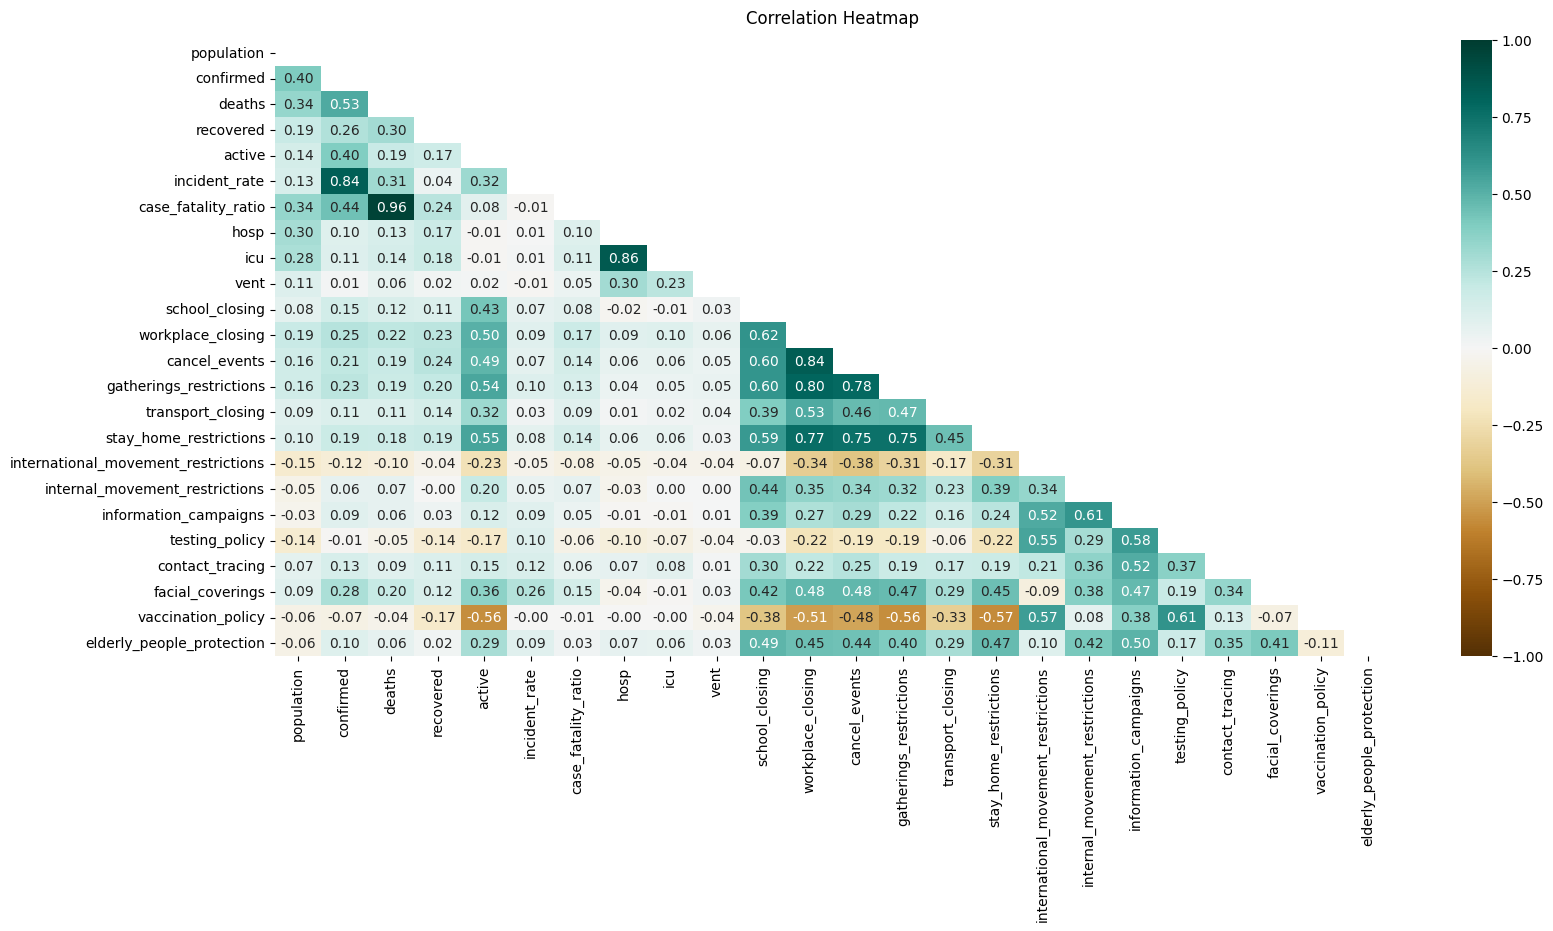

In [97]:
plt.figure(figsize=(18, 8))
corr_matrix = mart_df.corr(method="spearman")
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap="BrBG", center=0, fmt=".2f")
heatmap.set_title("Correlation Heatmap", fontdict={'fontsize':12}, pad=12);

### Interpretation
- Active cases has both positive and negative correlation on different government mandated policies
- Confirmed cases has a slightly positive correlation with wearing a face mask policy
- Testing policy and international movement restriction has a slightly negative correlation on our epidemiological varibles (confirmed, deaths, recovered, active)

### Taking a Closer Look on Each Epidemiological Variables

In [155]:
_ordinal_fields = [
    "school_closing", "workplace_closing", "cancel_events", "gatherings_restrictions",
    "transport_closing", "stay_home_restrictions", "international_movement_restrictions",
    "internal_movement_restrictions", "information_campaigns", "testing_policy",
    "contact_tracing", "facial_coverings", "vaccination_policy", "elderly_people_protection"
]
continuous_fields = ["confirmed", "deaths", "recovered", "active", "hosp", "icu", "vent", "vaccines", "tests"]

#### Confirmed Cases

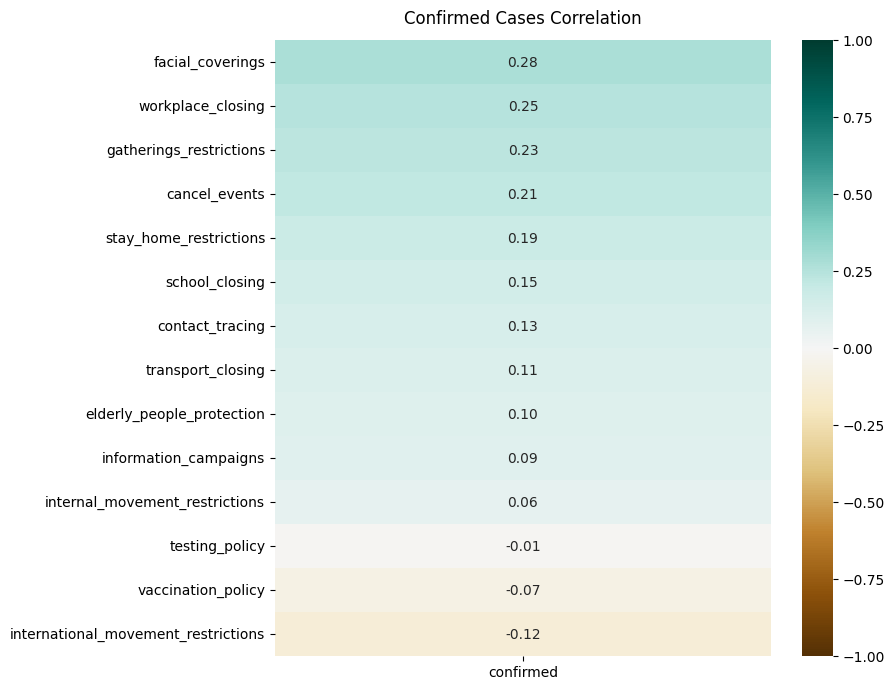

In [102]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="confirmed",
    other_fields=_ordinal_fields,
    title="Confirmed Cases Correlation"
)

In [141]:
def visualize_correlation(correlation_matrix: pd.DataFrame, continuous_var: str, other_fields: list[str], title: str):
    filtered_corr = correlation_matrix.loc[other_fields, [continuous_var]].sort_values(by=continuous_var, ascending=False)
    
    plt.figure(figsize=(8, 8))
    heatmap = sns.heatmap(filtered_corr, vmin=-1, vmax=1, annot=True, cmap="BrBG", center=0, fmt=".2f")
    heatmap.set_title(title, fontdict={"fontsize":12}, pad=12)

#### Interpretation
- We could see that there's a positive correlation on wearing a face mask and the number of confirmed cases which could be a response to the surge of confirmed cases rather than a side effect.
- International movement restriction and vaccination policy has a slight correlation with the number of confirmed cases which could mean that we could benefit from increasing the strictness of level of these 2 policies.

#### Death Cases

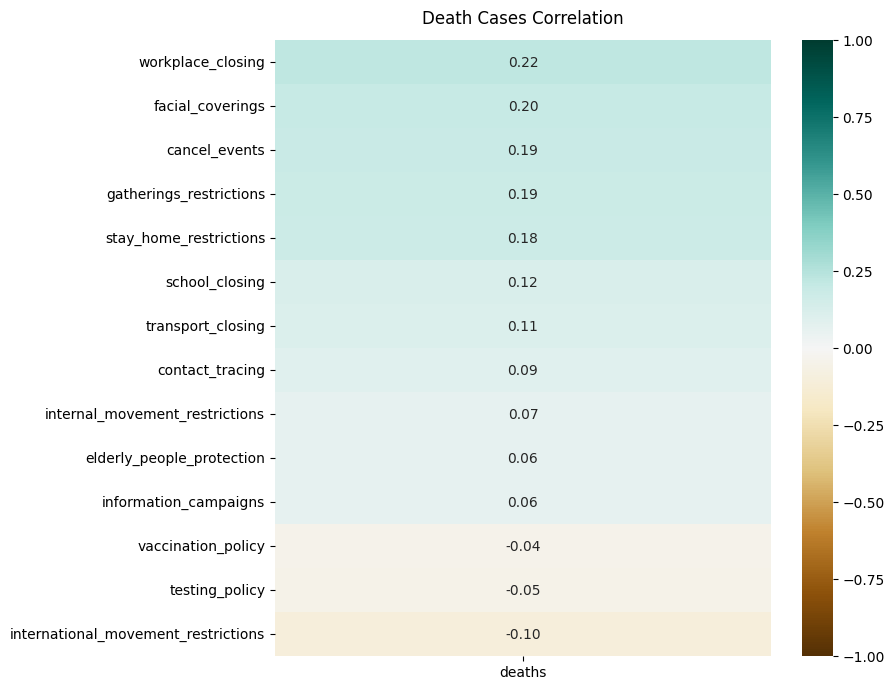

In [104]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="deaths",
    other_fields=_ordinal_fields,
    title="Death Cases Correlation"
)

#### Interpretation
- We could see that there are policies with positive correlation to the number of deaths. And this could be again, increasing the strictness level of a policy as a response rather than an effect to the number of deaths.
- International movement restriction and testing policy has a slight correlation with the number of confirmed cases which could mean that we could benefit from increasing the strictness of level of these 2 policies.

#### Recovered Cases

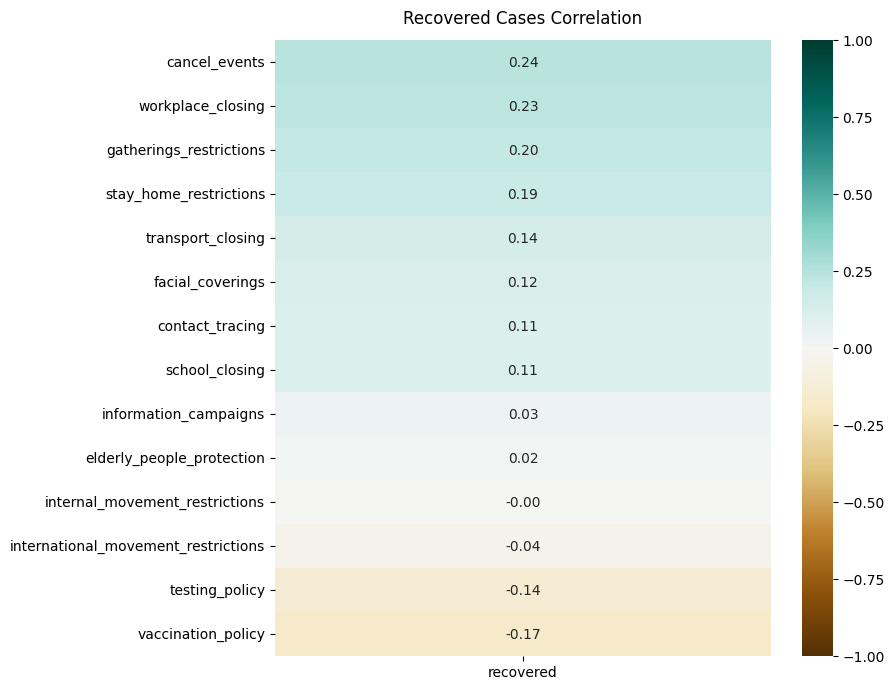

In [105]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="recovered",
    other_fields=_ordinal_fields,
    title="Recovered Cases Correlation"
)

#### Interpretation
- There were a small negative correlation on vaccination & testing policy to the number of recovered cases. This could mean that having a stricter testing and vaccination policy could lead to lesser number of recovery -- and that could be because of reduced number of new cases and hence no need for recovery

#### Hospitalization

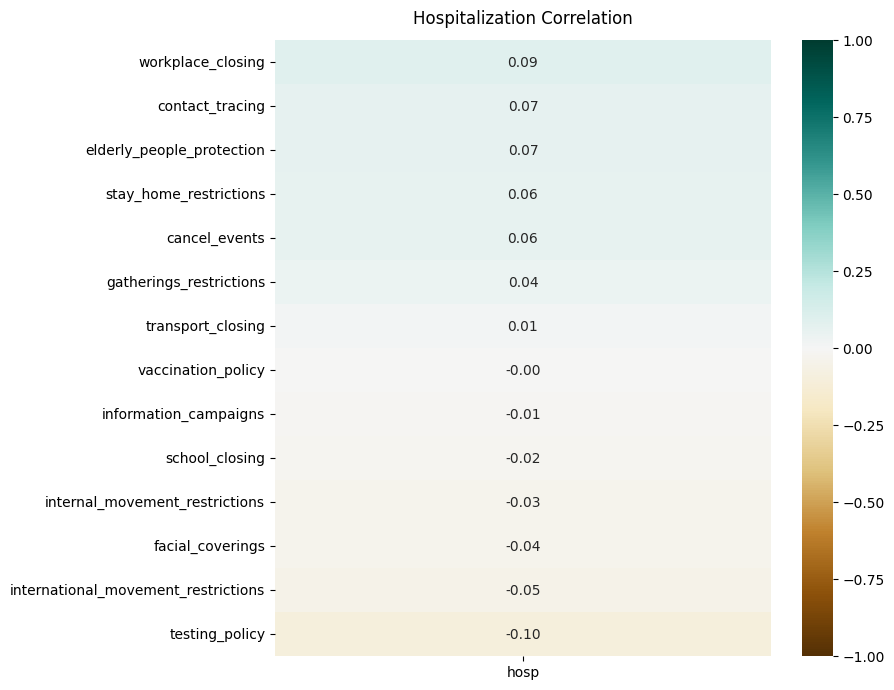

In [107]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="hosp",
    other_fields=_ordinal_fields,
    title="Hospitalization Correlation"
)

#### ICU Utilization

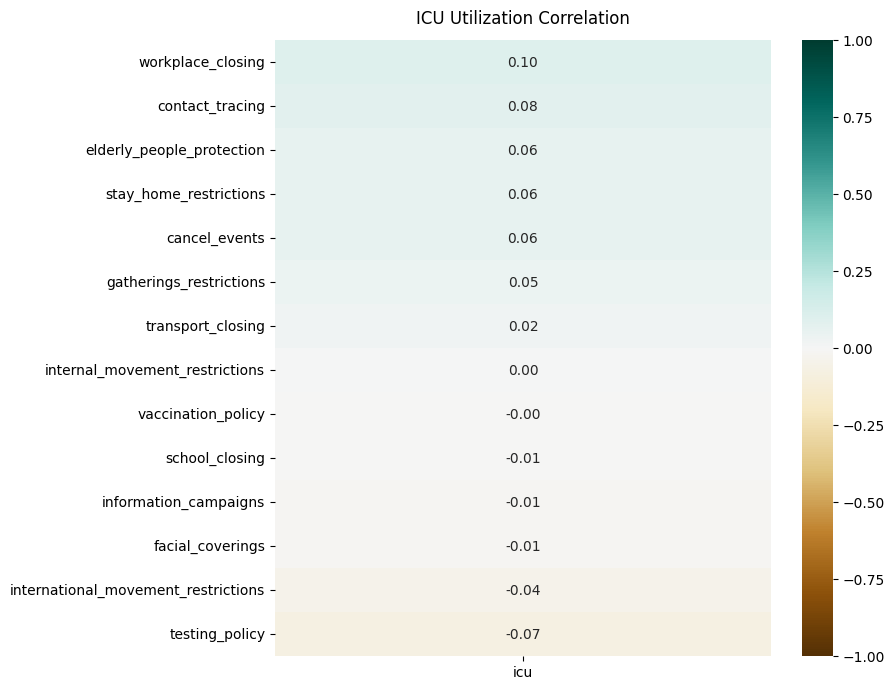

In [108]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="icu",
    other_fields=_ordinal_fields,
    title="ICU Utilization Correlation"
)

#### Ventilization Utilization

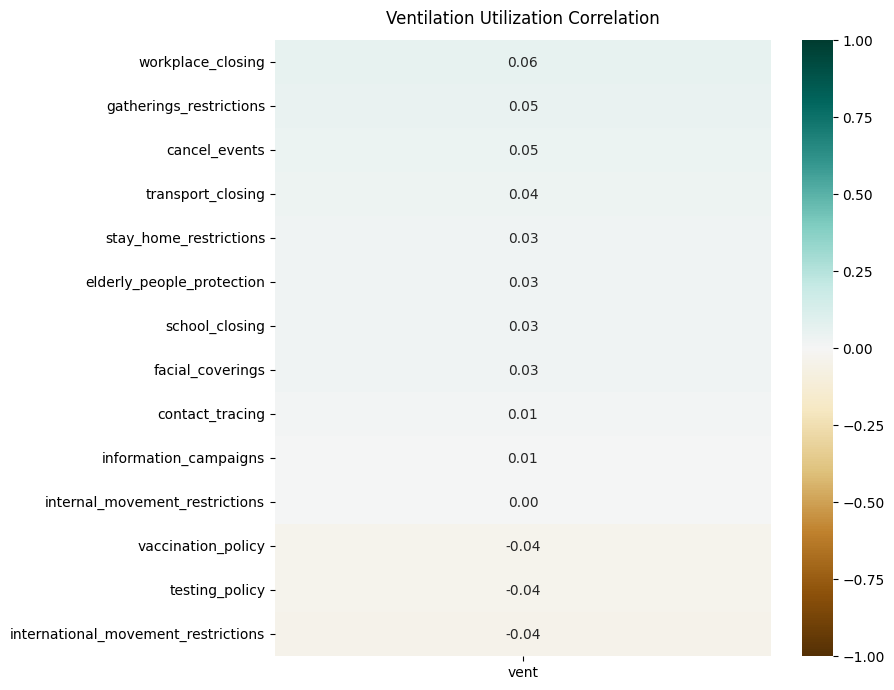

In [109]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="vent",
    other_fields=_ordinal_fields,
    title="Ventilation Utilization Correlation"
)

#### Activate Cases

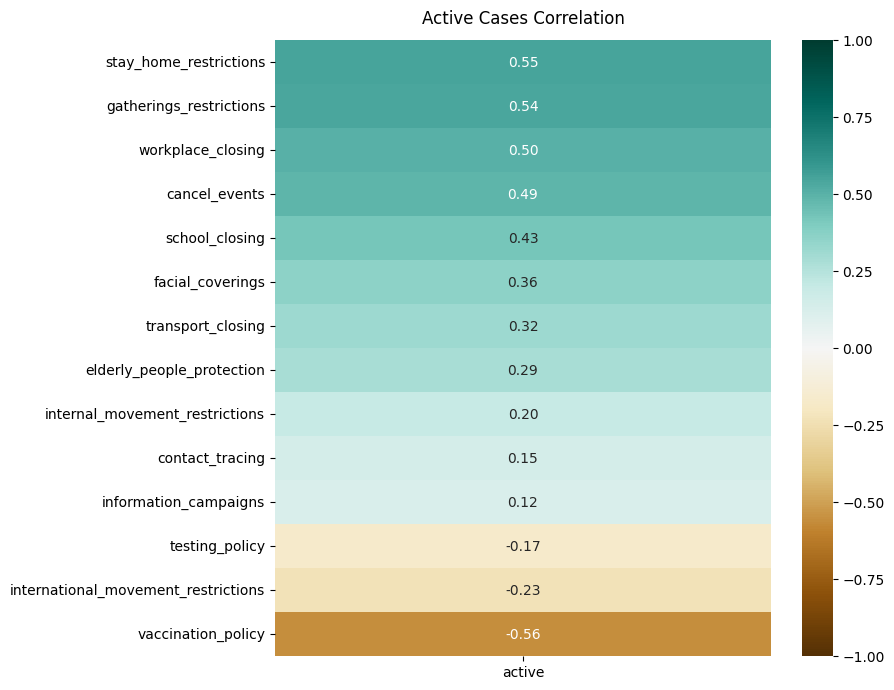

In [110]:
visualize_correlation(
    correlation_matrix=corr_matrix,
    continuous_var="active",
    other_fields=_ordinal_fields,
    title="Active Cases Correlation"
)

#### Interpretation
- Vaccination policy has a high negative correlation to the number of active cases. This means that mandating a stric vaccination could have some decreasing effect on the number of active cases
- We could also see that International Movement Restrictions and Testing Policy could help decrease the number of active cases

### Performing Lagged Correlation Analysis on Confirmed, Deaths, Recovered, and Active cases
We will calculate the value of these fields 7, 14, and 21 days ago, and we will see if each gov't policy has a lagged effect on our epidemiological variables. <br>
We will focus on these 4 variables as we saw a slightly good correlation on them as compared to hospitalization and tests variables.

In [151]:
week_lags = [7*i for i in range(1, 4)]
for lag in week_lags:
    for field in continuous_fields:
        mart_df[f"{field}_lag_{lag}"] = mart_df[field].shift(lag)

lagged_mart_df = mart_df.dropna(subset=[f"{field}_lag_{lag}" for lag in week_lags for field in continuous_fields])

In [152]:
lagged_s_corr_matrix = lagged_mart_df.corr(method="spearman")

In [200]:
def visualize_correlation_matrix(correlation_matrix: pd.DataFrame, continuous_vars: list[str], other_fields: list[str]):
    fig, axes = plt.subplots(1, 1, figsize=(17, 8), sharey=False)
    filtered_corr = correlation_matrix.loc[other_fields, continuous_vars].sort_values(by=continuous_vars, ascending=False)
    heatmap = sns.heatmap(filtered_corr, vmin=-1, vmax=1, annot=True, cmap="BrBG", center=0, fmt=".2f")
    heatmap.set_title(f"{continuous_vars[0]} Lagged Correlation Matrix".title(), fontdict={"fontsize":12}, pad=12)

    plt.tight_layout()
    plt.show()

#### Confirmed Cases and Government Policy Effects 7 / 14 / 21 Days Lag Effect

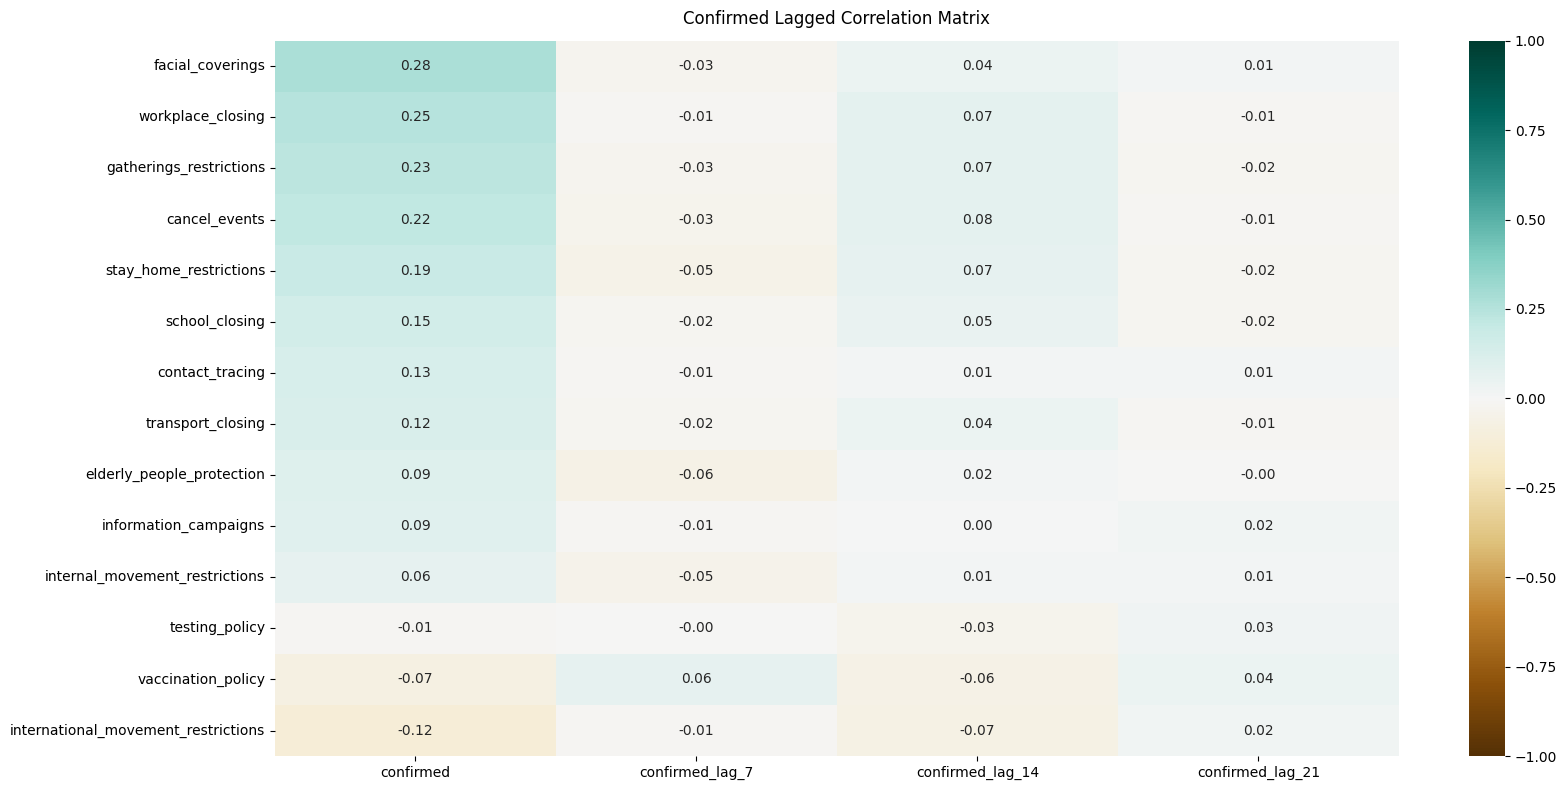

In [201]:
visualize_correlation_matrix(
    correlation_matrix=lagged_s_corr_matrix,
    continuous_vars=["confirmed"] + [f"confirmed_lag_{lag}" for lag in week_lags],
    other_fields=ordinal_fields
)

#### Interpretation
- 7 days after mandating stricter international movement restrictions, we could see some increase in correlation. This could be just a delay on the effect of the policy.
- We could also see that after 14 days, we could have a slight long term effect on increasing the level of international movement restrictions. However, it diminishes after 21 days.


#### Death Cases and Government Policy Effects 7 / 14 / 21 Days Lag Effect

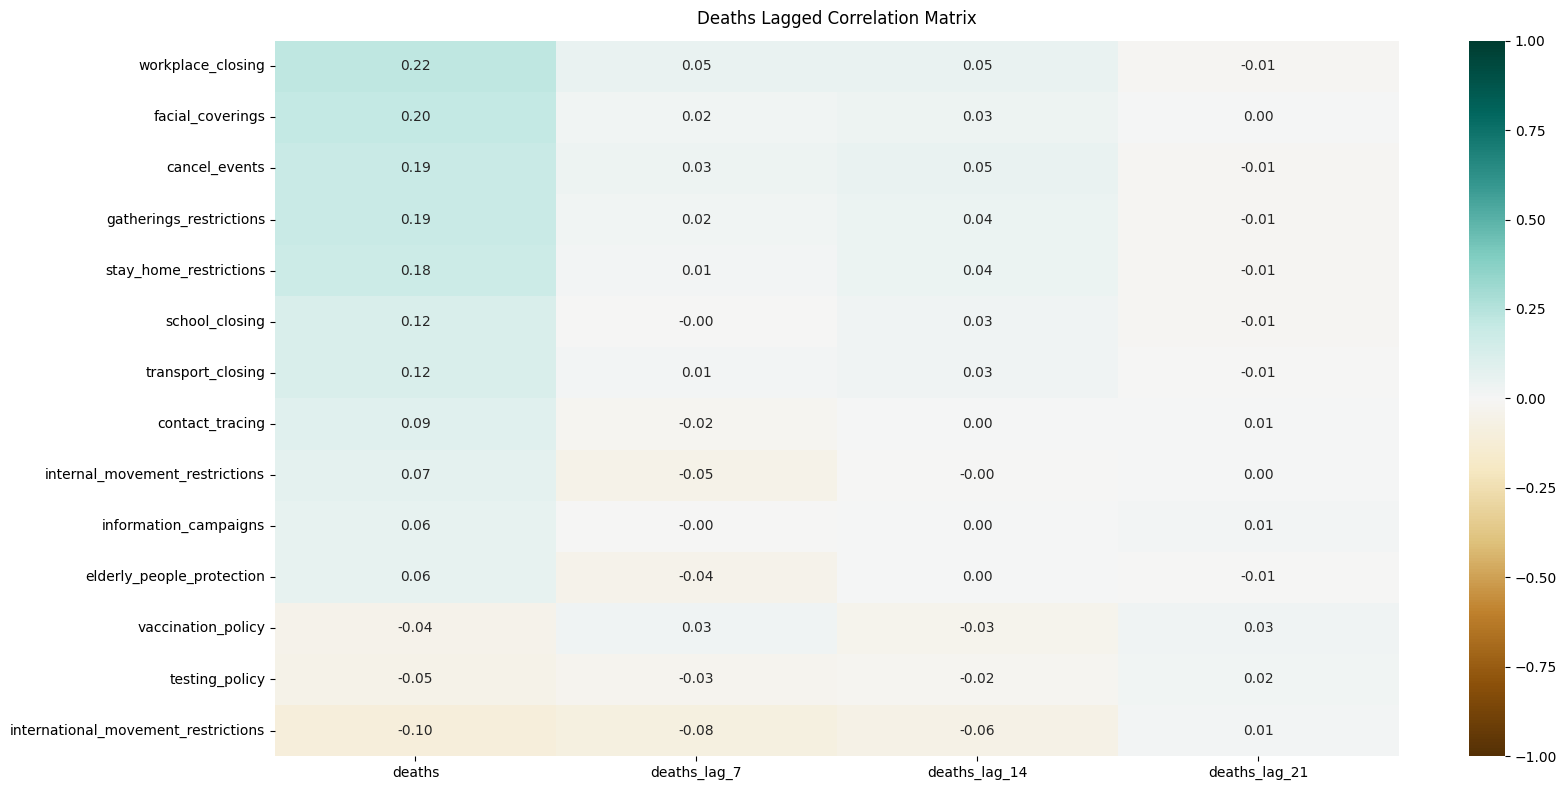

In [202]:
visualize_correlation_matrix(
    correlation_matrix=lagged_s_corr_matrix,
    continuous_vars=["deaths"] + [f"deaths_lag_{lag}" for lag in week_lags],
    other_fields=ordinal_fields
)

#### Interpretation
- We could see that 7, 14, & 21 days after mandating a strict international movement policy, the number of deaths slowly increases. And we can say that the velocity of increase in the number of deaths due to covid could be slowed down by having a stricter international movement policy.
- Similarly, testing policy has the same effect but it is less significant compared to international movement restrictions.

#### Recovered Cases and Government Policy Effects 7 / 14 / 21 Days Lag Effect

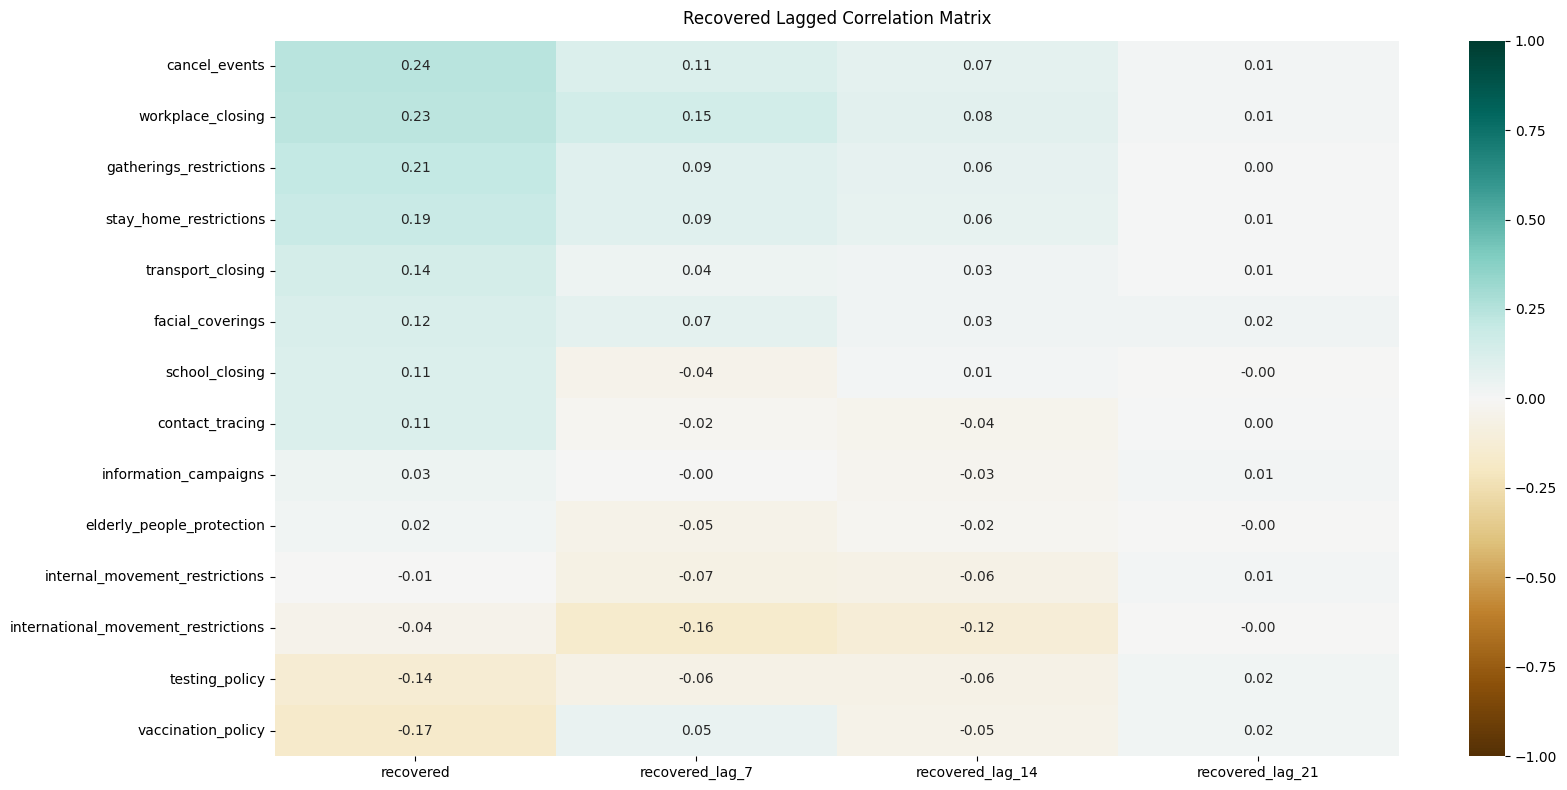

In [203]:
visualize_correlation_matrix(
    correlation_matrix=lagged_s_corr_matrix,
    continuous_vars=["recovered"] + [f"recovered_lag_{lag}" for lag in week_lags],
    other_fields=ordinal_fields
)

#### Interpretation
- We could see that after mandating a stricter testing, internal movement, international movement policies, their correlation to the number of recovered cases also decreases 7 days and 14 days after. This could mean a delayed effect of the policy

#### Active Cases and Government Policy Effects 7 / 14 / 21 Days Lag Effect

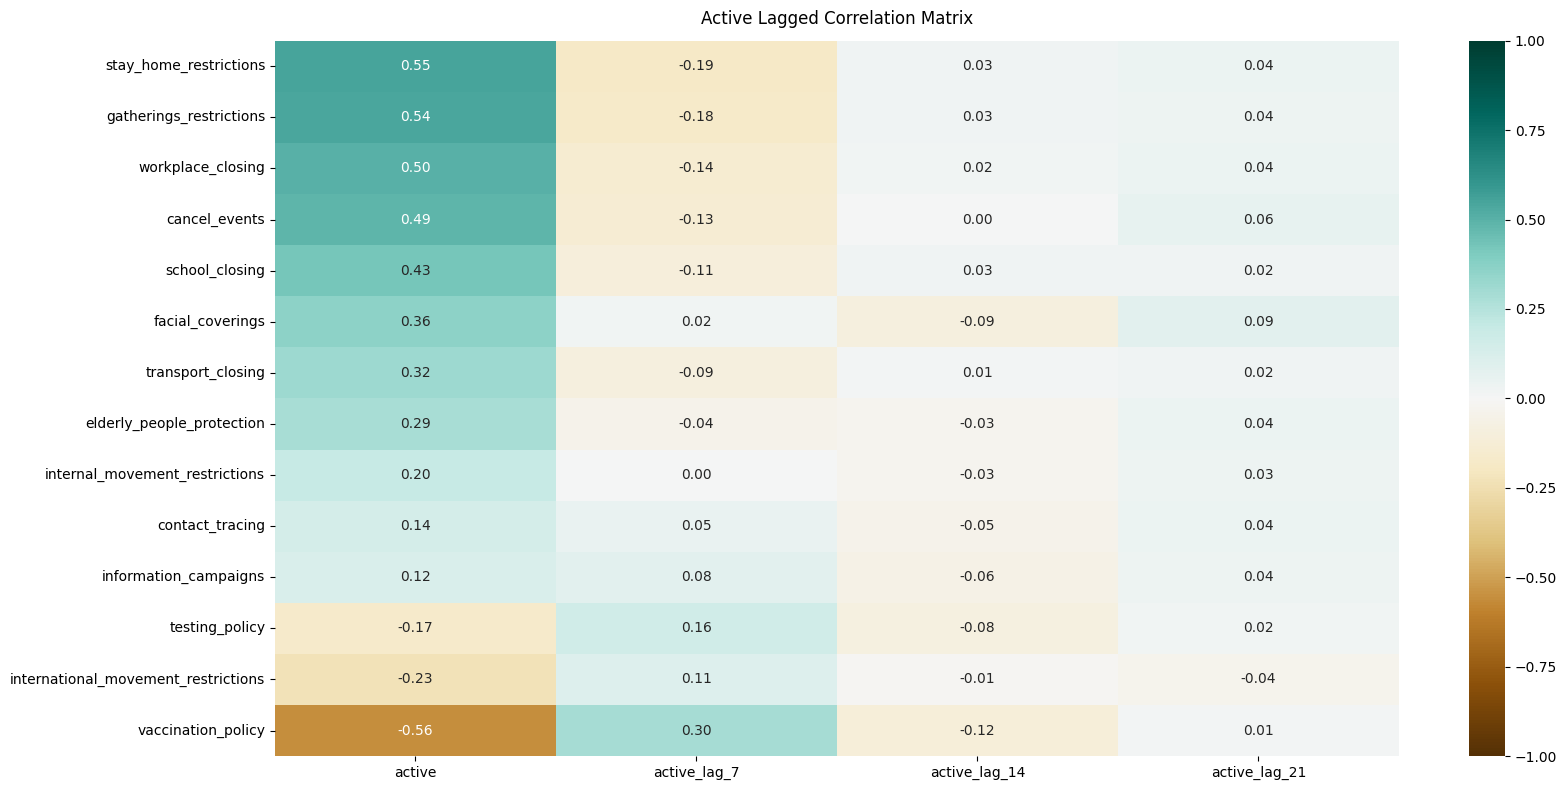

In [204]:
visualize_correlation_matrix(
    correlation_matrix=lagged_s_corr_matrix,
    continuous_vars=["active"] + [f"active_lag_{lag}" for lag in week_lags],
    other_fields=ordinal_fields
)

#### Interpretation
- The correlation of active cases with stay home, gathering, workplace, cancel events, and school closing policies decreases 7 days after its mandate but increases again 14 days and 21 days after
- Wearing a face mask correlation to active number of cases drop to negative correlation 14 days and 21 days after the mandate. This could mean a small long term benefit
- Meanwhile, contact tracing & information campaign policies have a gradual decrease on its correlation to active number of cases. This could imply a small long term benefit
- Lastly, testing, international movement, and vaccination policies' correlation to the number of active cases increases 7 days after the policy roll out but decreases again 14 days after -- which could be a delayed effect of the roll out